# Use pure numpy array

Despite the "x" in its name (indicating xarray-compatible), xESMF can also work with basic numpy arrays. You don't have to use xarray data structure if you don't need to track metadata. As long as you have numpy arrays describing the input data and input/output coordinate values, you can perform regridding.

Code in this section is adapted from [an xarray example](http://xarray.pydata.org/en/stable/plotting.html#multidimensional-coordinates).

In [1]:
# not importing xarray here!
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe

## Rectilinear grid

### Input data

Just make some fake data.

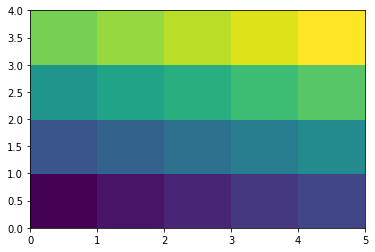

In [2]:
data = np.arange(20).reshape(4, 5)
plt.pcolormesh(data)

### Define grids

In previous examples we use xarray `DataSet` as input/output grids. But you can also use a simple dictionary:

In [3]:
grid_in = {'lon': np.linspace(0, 40, 5),
           'lat': np.linspace(0, 20, 4)
          }

# output grid has a larger coverage and finer resolution
grid_out = {'lon': np.linspace(-20, 60, 51),
            'lat': np.linspace(-10, 30, 41)
           }

### Perform regridding

In [4]:
regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
regridder.clean_weight_file()
regridder 

Create weight file: bilinear_4x5_41x51.nc
Remove file bilinear_4x5_41x51.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_4x5_41x51.nc 
Reuse pre-computed weights? False 
Input grid shape:           (4, 5) 
Output grid shape:          (41, 51) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

The `regridder` here has no difference from the ones made from xarray `DataSet`. You can use it to regrid `DataArray` or just a basic 2D numpy array:

In [5]:
data_out = regridder(data)  # regrid a basic 2D numpy array
data_out.shape

(41, 51)

### Check results

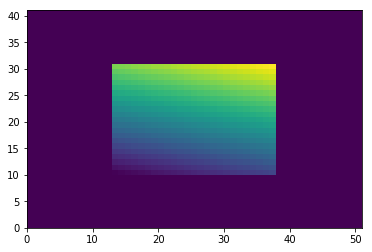

In [6]:
plt.pcolormesh(data_out)

## Curvilinear grid

### Grids

We use the previous input data, but now assume it is on a curvilinear grid described by 2D arrays. We also computed the cell corners, for two purposes:

- Visualization with `plt.pcolormesh` (using cell centers will miss one row&column)
- Conservative regridding with xESMF (corner information is required for conservative method)

In [7]:
# cell centers
lon, lat = np.meshgrid(np.linspace(-20, 20, 5), np.linspace(0, 30, 4))
lon += lat/3
lat += lon/3

# cell corners
lon_b, lat_b = np.meshgrid(np.linspace(-25, 25, 6), np.linspace(-5, 35, 5))
lon_b += lat_b/3
lat_b += lon_b/3

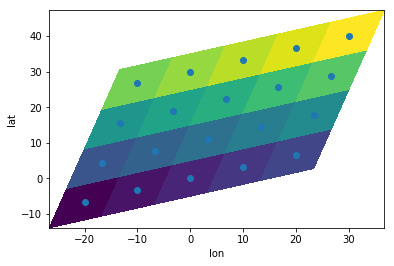

In [8]:
plt.pcolormesh(lon_b, lat_b, data)
plt.scatter(lon, lat)  # show cell center
plt.xlabel('lon')
plt.ylabel('lat')

For the output grid, just use a simple rectilinear one:

In [9]:
lon_out_b = np.linspace(-30, 40, 36)  # bounds 
lon_out = 0.5*(lon_out_b[1:]+lon_out_b[:-1]) # centers

lat_out_b = np.linspace(-20, 50, 36)
lat_out = 0.5*(lat_out_b[1:]+lat_out_b[:-1])

To use conservative algorithm, both input and output grids should contain 4 variables: `lon`, `lat`, `lon_b`, `lon_b`.

In [10]:
grid_in = {'lon': lon, 'lat': lat,
           'lon_b': lon_b, 'lat_b': lat_b}

grid_out = {'lon': lon_out, 'lat': lat_out,
           'lon_b': lon_out_b, 'lat_b': lat_out_b}

### Regridding

In [11]:
regridder = xe.Regridder(grid_in, grid_out, 'conservative')
regridder.clean_weight_file()
regridder 

Create weight file: conservative_4x5_35x35.nc
Remove file conservative_4x5_35x35.nc


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_4x5_35x35.nc 
Reuse pre-computed weights? False 
Input grid shape:           (4, 5) 
Output grid shape:          (35, 35) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [12]:
data_out = regridder(data)
data_out.shape

(35, 35)

### Results

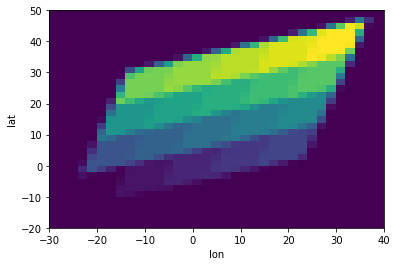

In [13]:
plt.pcolormesh(lon_out_b, lat_out_b, data_out)
plt.xlabel('lon')
plt.ylabel('lat')

## All possible combinations

All $2 \times 2\times 2 = 8$ combinations would work:

- Input grid: `xarray.DataSet` or `dict`
- Output grid: `xarray.DataSet` or `dict`
- Input data: `xarray.DataArray` or `numpy.ndarray`

The output data type will be the same as input data.